In [16]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from collections import OrderedDict

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# Reproducibility
torch.manual_seed(0)
random.seed(0)

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='/home/fariselli/Datasets/cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/fariselli/Datasets/cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


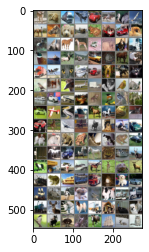

deer  cat   truck plane car   horse bird  plane horse horse dog   truck frog  truck truck dog   deer  bird  horse dog   frog  deer  cat   truck bird  ship  deer  truck car   cat   horse cat   truck plane cat   ship  truck dog   horse cat   bird  dog   bird  plane truck cat   bird  bird  ship  car   plane plane dog   bird  bird  frog  car   plane bird  ship  horse horse bird  cat   car   horse plane horse horse dog   truck car   dog   dog   frog  frog  cat   cat   frog  car   bird  horse car   horse horse frog  ship  deer  horse truck plane ship  horse deer  frog  deer  plane frog  ship  car   truck frog  dog   car   ship  frog  horse dog   bird  dog   ship  truck truck deer  horse dog   truck truck bird  dog   bird  dog   bird  deer  horse ship  deer  cat  


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, layer_id, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(OrderedDict([
                (f"conv", nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False)),
                (f"bn", nn.BatchNorm2d(out_planes)),
                (f"relu", nn.ReLU(inplace=True))
            ])
        )

class NetLayer(nn.Sequential):
    def __init__(self, layer_id, in_feat, out_feat):
        super(NetLayer, self).__init__(OrderedDict([
                (f"convbnrelu0", ConvBNReLU(layer_id, in_feat, out_feat, 3, 1)),
                (f"convbnrelu1", ConvBNReLU(layer_id, out_feat, out_feat, 3, 1)),
                (f"pool", nn.MaxPool2d(2))
            ])
        )

class Net(nn.Module):
    def __init__(self, quant=False):
        super().__init__()
        self.layer0 = NetLayer(0, 3, 32)
        self.layer1 = NetLayer(1, 32, 64)
        self.layer2 = NetLayer(2, 64, 128)

        self.fc1 = nn.Linear(2048, 128)
        #self.fcbn = nn.BatchNorm1d(128) # not supported the fusion linear + bn in pytorch quant
        #self.fc1relu = nn.ReLU(inplace=True) # not supported linear + relu in export for onnx

        self.fc2 = nn.Linear(128, 10)
        if quant: 
            # QuantStub converts tensors from floating point to quantized
            self.quant = torch.quantization.QuantStub()
            # DeQuantStub converts tensors from quantized to floating point
            self.dequant = torch.quantization.DeQuantStub()
        else:
            self.quant = None
            self.dequant = None


    def forward(self, x):
        if self.quant:
            x = self.quant(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        #x = self.fc1relu(x)
        x = self.fc2(x)
        if self.dequant:
            x = self.dequant(x)
        return x


net = Net(quant=True).to(device)
net

Net(
  (layer0): NetLayer(
    (convbnrelu0): ConvBNReLU(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (convbnrelu1): ConvBNReLU(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): NetLayer(
    (convbnrelu0): ConvBNReLU(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (convbnrelu1): ConvBNReLU(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padd

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
n_epochs = 10

def test(model, testloader, device):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def train(model, n_epochs, trainloader, testloader, optimizer, criterion, device):
    train_accuracy = []
    val_accuracy = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(tqdm(trainloader, 0)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
             # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        train_accuracy.append(correct / total)
        val_accuracy.append(test(model, testloader, device))
        print(f"Accuracy epoch {epoch}: Train: {train_accuracy[-1] * 100:.2f}% Test: {val_accuracy[-1] * 100:.2f}%")
    print('Finished Training')
    return train_accuracy, val_accuracy

In [8]:
pretrained = True
PATH = "model/pytorch_training/cifar10.pth"
if not os.path.exists(os.path.split(PATH)[0]):
    os.mkdir(os.path.split(PATH)[0])

if pretrained:
    checkpoint = torch.load(PATH)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    n_epoch = checkpoint['epoch']
    train_acc = checkpoint['train_acc']
    val_acc = checkpoint['val_acc']
else:
    n_epochs = 10
    train_acc, val_acc = train(net, n_epochs, trainloader, testloader, optimizer, criterion, device)
    torch.save({
        'epoch': n_epochs,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_acc': train_acc,
        'val_acc': val_acc
        }, PATH)



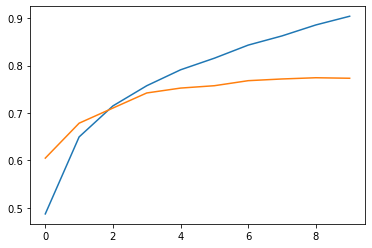

In [9]:
plt.plot(np.array(train_acc))
plt.plot(np.array(val_acc))

In [10]:
val_accuracy = test(net, testloader, device)
print(f"Test accuracy: {val_accuracy * 100} %")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.40it/s]

Test accuracy: 77.32 %


# PTQ

In [11]:
torch.__version__

'1.12.0+cu102'

In [12]:
batch = next(iter(trainloader))

input_, target_ = batch

In [13]:
# model must be set to eval mode for static quantization logic to work
net.to("cpu")
net.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'fbgemm' for server inference and
# 'qnnpack' for mobile inference. Other quantization configurations such
# as selecting symmetric or assymetric quantization and MinMax or L2Norm
# calibration techniques can be specified here.
backend = "qnnpack"
net.qconfig = torch.quantization.get_default_qconfig('fbgemm')
print(net.qconfig)

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`

layer_fused = [[f'layer{i}.convbnrelu0.conv', f'layer{i}.convbnrelu0.bn', f'layer{i}.convbnrelu0.relu'] for i in range(3)] + \
              [[f'layer{i}.convbnrelu1.conv', f'layer{i}.convbnrelu1.bn', f'layer{i}.convbnrelu1.relu'] for i in range(3)]
#              [["fc1", "fc1relu"]]

model_fp32_fused = torch.quantization.fuse_modules(net, layer_fused)

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.quantization.prepare(model_fp32_fused)
model_fp32_prepared

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
input_fp32 = input_
model_fp32_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.quantization.convert(model_fp32_prepared)


QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


/home/fariselli/.local/lib/python3.8/site-packages/torch/ao/quantization/observer.py:176: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [14]:
# run the model, relevant calculations will happen in int8
res = model_int8(input_fp32)

In [15]:
val_accuracy = test(model_int8, testloader, "cpu")
print(f"Test accuracy: {val_accuracy * 100} %")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.51it/s]

Test accuracy: 77.58 %


In [16]:
model_int8

Net(
  (layer0): NetLayer(
    (convbnrelu0): ConvBNReLU(
      (conv): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.04967612400650978, zero_point=0, padding=(1, 1))
      (bn): Identity()
      (relu): Identity()
    )
    (convbnrelu1): ConvBNReLU(
      (conv): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.054228026419878006, zero_point=0, padding=(1, 1))
      (bn): Identity()
      (relu): Identity()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): NetLayer(
    (convbnrelu0): ConvBNReLU(
      (conv): QuantizedConvReLU2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.04852055758237839, zero_point=0, padding=(1, 1))
      (bn): Identity()
      (relu): Identity()
    )
    (convbnrelu1): ConvBNReLU(
      (conv): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.04564452916383743, zero_point=0, padding=(1, 1))
      (bn): Identity()
      (relu): I

In [7]:
ONNX_PATH = "quant_cifar10.onnx"

In [17]:
my_input = torch.randn(1, 3, 32, 32, device='cpu')
# enable_onnx_checker needs to be disabled. See notes below.
model_int8.eval()
torch.onnx.export(
    model_int8, my_input, ONNX_PATH, verbose=True)

Exported graph: graph(%x.1 : Float(1, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu),
      %onnx::QuantizeLinear_259 : Byte(requires_grad=0, device=cpu),
      %onnx::QuantizeLinear_260 : Float(requires_grad=0, device=cpu),
      %onnx::DequantizeLinear_263 : Char(32, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::DequantizeLinear_264 : Float(32, strides=[1], requires_grad=0, device=cpu),
      %onnx::DequantizeLinear_265 : Char(32, strides=[1], requires_grad=0, device=cpu),
      %onnx::ConstantOfShape_267 : Long(1, strides=[1], requires_grad=0, device=cpu),
      %onnx::DequantizeLinear_270 : Int(32, strides=[1], requires_grad=0, device=cpu),
      %onnx::DequantizeLinear_271 : Float(32, strides=[1], requires_grad=0, device=cpu),
      %onnx::QuantizeLinear_272 : Float(requires_grad=0, device=cpu),
      %onnx::QuantizeLinear_273 : Byte(requires_grad=0, device=cpu),
      %onnx::DequantizeLinear_276 : Char(32, 32, 3, 3, strides=[288,

# Test ONNX

In [42]:
import onnx
import onnxruntime as ort

In [65]:
def onnx_one_sample(model_path, dummy_input):
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    output = sess.run(None, {input_name: dummy_input})
    output = np.asarray(output)
    return output

def onnx_layer_output(onnx_model_path, dummy_input):
    ort_session = ort.InferenceSession(onnx_model_path)
    org_outputs = [x.name for x in ort_session.get_outputs()]
    model = onnx.load(onnx_model_path)
    for node in model.graph.node:
        for output in node.output:
            if output not in org_outputs:
                model.graph.output.extend([onnx.ValueInfoProto(name=output)])

    # excute onnx
    ort_session = ort.InferenceSession(model.SerializeToString())
    outputs = [x.name for x in ort_session.get_outputs()]
    nodes = org_outputs + [node.name for node in model.graph.node]
    ort_inputs = {ort_session.get_inputs()[0].name: dummy_input}
    ort_outs = ort_session.run(outputs, ort_inputs)
    outputs = ort_outs = OrderedDict(zip(nodes, ort_outs))
    return outputs

def onnx_inference(model_path, dataloader):
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    total = 0
    correct = 0
    for data in tqdm(dataloader):
        images, labels = data[0].to("cpu").detach().numpy(), data[1].to("cpu").detach().numpy()

        outputs = []
        for image, label in zip(images, labels):
            # calculate outputs by running images through the network
            output = sess.run(None, {input_name: np.expand_dims(image, axis=0)})
            outputs.append(np.asarray(output)[0][0])

        # the class with the highest energy is what we choose as prediction
        predicted = np.argmax(np.array(outputs), -1)
        total += labels.size
        correct += (predicted == labels).sum().item()

    return correct / total

In [12]:
onnx_accuracy = onnx_inference(ONNX_PATH, testloader)
print(f"ONNX Accuracy: {onnx_accuracy * 100:.2f}%")

NameError: name 'ONNX_PATH' is not defined

# NNTool

In [17]:
from nntool.api import NNGraph

In [18]:
G = NNGraph.load_graph(ONNX_PATH)
G.quantize(None, graph_options={"use_ne16": True})
G.adjust_order()
G.fusions("scaled_match_group")
G.draw(quant_labels=True, fusions=True, view=False, filepath="nntool_graph")

unable to determine batch dimension. if the graph fails to import properly set it to 1 or a variable.
indicating change of Gemm_116 input from c, out_cin_c, out_c to chw, out_cin_chw, out_c order - rerun adjust command
indicating change of Gemm_116 output from c to chw order - rerun adjust command
indicating change of Gemm_124 input from c, out_cin_c, out_c to chw, out_cin_chw, out_c order - rerun adjust command
indicating change of Gemm_124 output from c to chw order - rerun adjust command
indicating change of Conv_46 input from chw, out_cin_chw, out_c to hwc, out_cin_chw, out_c order - rerun adjust command
indicating change of Conv_46 output from chw to hwc order - rerun adjust command
indicating change of Conv_55 input from chw, out_cin_chw, out_c to hwc, out_cin_chw, out_c order - rerun adjust command
indicating change of Conv_55 output from chw to hwc order - rerun adjust command
indicating change of MaxPool_60 input from chw to hwc order - rerun adjust command
indicating change o

WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING: float_scale TRUEEEEE
WAAAARNING

In [23]:

def nntool_inference(graph, dataloader):
    total = 0
    correct = 0
    for data in tqdm(dataloader):
        images, labels = data[0].to("cpu").detach().numpy(), data[1].to("cpu").detach().numpy()

        outputs = []
        for image, label in zip(images, labels):
            # calculate outputs by running images through the network
            input_data = image.transpose(1,2,0)
            output = G.execute([input_data], dequantize=True)[-1][0]
            outputs.append(output)

        # the class with the highest energy is what we choose as prediction
        predicted = np.argmax(np.array(outputs), -1)
        total += labels.size
        correct += (predicted == labels).sum().item()

    return correct / total

In [24]:
nntool_inference(G, testloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [11:55<00:00,  9.06s/it]


0.1856

In [66]:
images, labels = next(iter(testloader))
image = images.to("cpu").detach().numpy()
input_data = image[0].transpose(1,2,0)
foutput = G.execute([input_data])
output = G.execute([input_data], dequantize=True)
onnx_output = onnx_one_sample(ONNX_PATH, image[0:1])
onnx_layer_output = onnx_layer_output(ONNX_PATH, image[0:1])

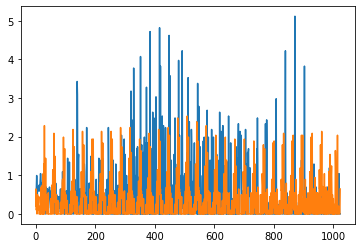

In [84]:
plt.plot(onnx_layer_output["DequantizeLinear_50"][0, 0].flatten())
plt.plot(output[3][0][0].flatten())

In [81]:
foutput[3][0].

(32, 32, 32)

In [72]:
for key, value in onnx_layer_output.items():
    print(key)

258
Identity_0
Identity_1
Identity_2
Identity_3
Identity_4
Identity_5
Identity_6
Identity_7
Identity_8
Identity_9
Identity_10
Identity_11
Identity_12
Identity_13
Identity_14
Identity_15
Identity_16
Identity_17
Identity_18
Identity_19
Identity_20
Identity_21
Identity_22
Identity_23
Identity_24
Identity_25
Identity_26
Identity_27
Identity_28
Identity_29
Identity_30
Identity_31
Identity_32
Identity_33
Identity_34
Identity_35
Identity_36
Identity_37
Identity_38
QuantizeLinear_39
Cast_40
DequantizeLinear_41
DequantizeLinear_42
ConstantOfShape_43
Cast_44
DequantizeLinear_45
Conv_46
Relu_47
QuantizeLinear_48
Cast_49
DequantizeLinear_50
DequantizeLinear_51
ConstantOfShape_52
Cast_53
DequantizeLinear_54
Conv_55
Relu_56
QuantizeLinear_57
Cast_58
DequantizeLinear_59
MaxPool_60
QuantizeLinear_61
Cast_62
DequantizeLinear_63
DequantizeLinear_64
ConstantOfShape_65
Cast_66
DequantizeLinear_67
Conv_68
Relu_69
QuantizeLinear_70
Cast_71
DequantizeLinear_72
DequantizeLinear_73
ConstantOfShape_74
Cast_75
D

In [49]:
qsnrs = G.qsnrs(foutput, output)
for i, q in enumerate(qsnrs):
    print(i, q)

0 40
1 53
2 71
3 33
4 49
5 93
6 33
7 48
8 95
9 30
10 48
11 98
12 30
13 49
14 102
15 27
16 50
17 101
18 27
19 48
20 97
21 0
22 53
23 85
24 0
25 0


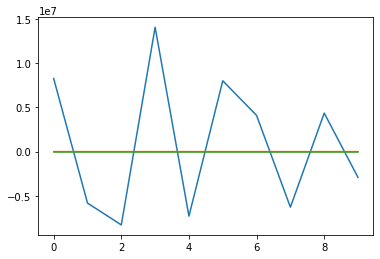

In [51]:
plt.plot(foutput[25][0].flatten())
plt.plot(output[25][0].flatten())
plt.plot(onnx_output.flatten())

In [55]:
foutput[25][0]

array([ 8284451.5, -5833281.5, -8309974. , 14090389. , -7314160. ,
        8023503. ,  4099020.8, -6301377. ,  4361691.5, -2929299.2],
      dtype=float32)

In [54]:
output[25][0]

array([ 44.67752558, -45.02931712, -45.02931712,  44.67752558,
       -45.02931712,  44.67752558,  44.67752558, -45.02931712,
        44.67752558, -45.02931712])

In [52]:
onnx_output

array([ 2.992753 , -2.992753 , -2.7789848,  6.413042 , -3.847825 ,
        2.992753 ,  1.4963765, -2.7789848,  1.9239125, -1.4963765],
      dtype=float32)